In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, r2_score
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns

# Các hàm để xử lý dữ liệu

In [19]:
def preprocess_data(filepath):
    df = pd.read_csv(filepath)
    print("Raw data information:")
    print("Rows:", df.shape[0], "Columns:", df.shape[1])
    print("Columns:", list(df.columns))

    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
    print("Missing values before:", df.isnull().sum().sum())
    df = df.dropna()
    print("Missing values after:", df.isnull().sum().sum())

    df = df.drop(columns=["customerID"])

    X = df.drop("Churn", axis=1)
    y = df["Churn"]

    y_encoded = LabelEncoder().fit_transform(y)
    X_encoded = pd.get_dummies(X, drop_first=True)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_encoded)

    print("Final shape:", X_scaled.shape)
    print("Number of features:", X_scaled.shape[1])

    return df, X_scaled, y_encoded, X_encoded.columns.tolist()

In [20]:
def find_optimal_components_by_variance(X_scaled, variance_threshold):

    pca = PCA(n_components=None)
    pca.fit(X_scaled)

    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    optimal_components = np.argmax(cumulative_variance >= variance_threshold) + 1

    return optimal_components

In [21]:
def perform_pca(X_scaled, n_components):

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio) * 100

    for i in range(n_components):
        print(f"Principal Component {i+1}: {explained_variance_ratio[i]*100:.2f}%   |   Cumulative: {cumulative_variance[i]:.2f}%")

    print("-" * 42)

    total_variance_captured = np.sum(explained_variance_ratio)
    information_loss = 1 - total_variance_captured

    print(f"Total variance captured by {n_components} components: {total_variance_captured:.2%}")
    print(f"Amount of information lost after reduction: {information_loss:.2%}")
    print("-" * 42)

    return X_pca, pca

In [22]:
def perform_lda(X_scaled, y_encoded):

    lda = LDA(n_components=1)
    X_lda = lda.fit_transform(X_scaled, y_encoded)
    class_labels = np.where(y_encoded == 1, "Churn", "No Churn")
    df_temp = pd.DataFrame({"LDA1": X_lda.flatten(), "Class": class_labels})

    print("LDA Class Means")
    print(df_temp.groupby("Class").mean())

    return X_lda, lda

# Đọc dữ liệu đầu vào 

In [23]:
filepath = '/home/vitquay1708/Study_Space/ml/btl/data/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df_raw, X_processed, y_processed, feature_names = preprocess_data(filepath)



Raw data information:
Rows: 7043 Columns: 21
Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
Missing values before: 11
Missing values after: 0
Final shape: (7032, 30)
Number of features: 30


# Chia train - test

## Tỷ lệ 6:4

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, train_size=0.6, random_state=42, stratify=y_processed)

### Giảm chiều với PCA

In [25]:
# Tìm số chiều tối ưu cho PCA với phương sai giữ lại 0,9
pca64 = PCA(n_components=0.9)
X_train_pca = pca64.fit_transform(X_train)
X_test_pca = pca64.transform(X_test)
print(X_train_pca.shape)

(4219, 15)


### Giảm chiều với LDA

In [26]:
lda64 = LDA(n_components=1)
X_train_lda = lda64.fit_transform(X_train, y_train)
X_test_lda = lda64.transform(X_test)
print(X_train_lda.shape)

(4219, 1)


### Tìm siêu tham số với từng phương pháp

Original best params: {'C': np.float64(0.001), 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
Original best recall: 0.798
PCA best params: {'C': np.float64(0.001), 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
PCA best recall: 0.790
LDA best params: {'C': np.float64(0.001), 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
LDA best recall: 0.766


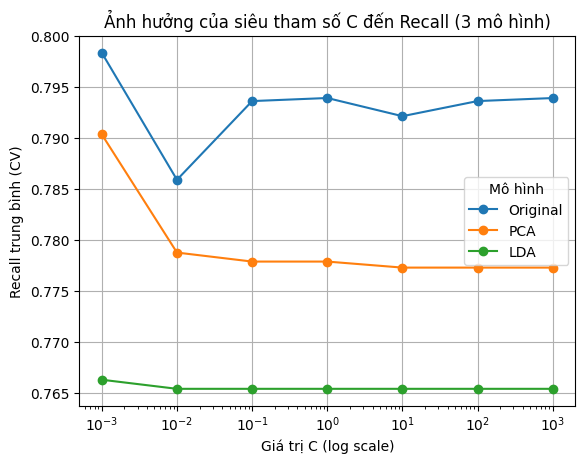

In [27]:
param_grid = {
    'C': np.logspace(-3, 3, 7),
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga', 'newton-cg'],
    'class_weight': ['balanced']
}

models = {
    "Original": X_train,
    "PCA": X_train_pca,
    "LDA": X_train_lda
}

for name, X in models.items():
    grid = GridSearchCV(LogisticRegression(max_iter=10000, random_state = 42), param_grid, cv=5, scoring='recall')
    grid.fit(X, y_train)
    print(f"{name} best params: {grid.best_params_}")
    print(f"{name} best recall: {grid.best_score_:.3f}")

    results = grid.cv_results_
    C_values = np.array(results['param_C'], dtype=float)
    mean_recalls = results['mean_test_score']


    results = grid.cv_results_
    C_values = np.array(results['param_C'], dtype=float)
    mean_recalls = results['mean_test_score']

    # Gộp recall trung bình theo từng giá trị C
    unique_C = np.unique(C_values)
    avg_recalls = [np.mean(mean_recalls[C_values == c]) for c in unique_C]

    # Vẽ mỗi mô hình là một đường
    plt.plot(unique_C, avg_recalls, marker='o', label=name)

# Định dạng biểu đồ
plt.xscale('log')
plt.xlabel('Giá trị C (log scale)')
plt.ylabel('Recall trung bình (CV)')
plt.title('Ảnh hưởng của siêu tham số C đến Recall (3 mô hình)')
plt.grid(True)
plt.legend(title='Mô hình')
plt.show()


### Áp dụng vào mô hình

#### Dữ liệu gốc

Accuracy train: 0.7458
Accuracy: 0.7235
Precision: 0.4875
Recall: 0.7834
F1-score: 0.6010
Confusion Matrix:
[[725 308]
 [ 81 293]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.78      0.60       374

    accuracy                           0.72      1407
   macro avg       0.69      0.74      0.69      1407
weighted avg       0.79      0.72      0.74      1407



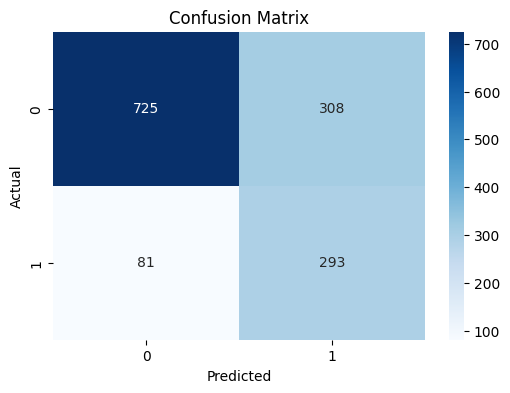

In [46]:
lr = LogisticRegression(C = 0.001, class_weight='balanced', penalty='l2', solver = 'lbfgs', random_state = 42, max_iter = 10000)
lr.fit(X_train, y_train)
print(f"Accuracy train: {lr.score(X_train, y_train):.4f}")
y_pred = lr.predict(X_test)
# 1️⃣ Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

# 2️⃣ Precision
prec = precision_score(y_test, y_pred)
print(f"Precision: {prec:.4f}")

# 3️⃣ Recall
rec = recall_score(y_test, y_pred)
print(f"Recall: {rec:.4f}")

# 4️⃣ F1-score
f1 = f1_score(y_test, y_pred)
print(f"F1-score: {f1:.4f}")

# 5️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# 6️⃣ Hoặc in nhanh tất cả các chỉ số cho từng lớp
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

##### Hồi quy với class 1 - Churn

MAE: 0.013846240135138042
MSE: 0.0003113839215250481
R² train: 0.99422210594011
R² test: 0.9944600690224351


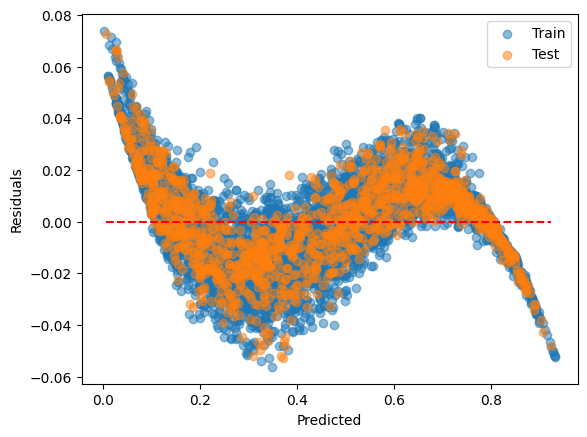

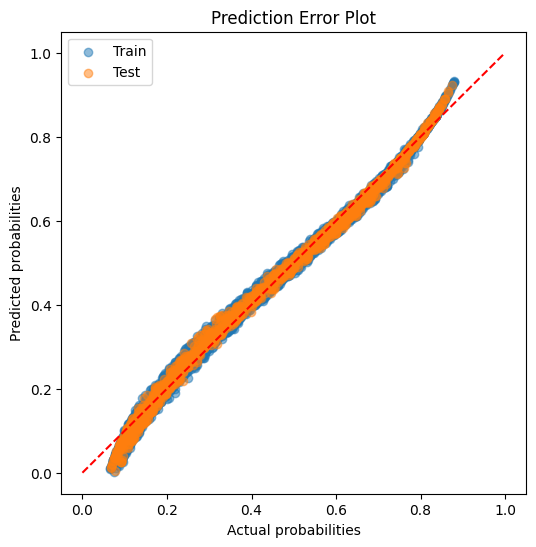

In [ ]:
## Lấy ra xác suất của train và test làm nhãn y cho bài toán hồi quy
y_train_regr = lr.predict_proba(X_train)[:, 1]
y_test_regr = lr.predict_proba(X_test)[:, 1]

linr = LinearRegression()
linr.fit(X_train,y_train_regr)
y_test_pred_regr = linr.predict(X_test)
y_train_pred_regr = linr.predict(X_train)
mae = mean_absolute_error(y_test_regr, y_test_pred_regr)
mse = mean_squared_error(y_test_regr, y_test_pred_regr)
r2_test = r2_score(y_test_regr, y_test_pred_regr)
r2_train = r2_score(y_train_regr, y_train_pred_regr)
print("MAE:", mae)
print("MSE:", mse)
print("R² train:", r2_train)
print("R² test:", r2_test)

# Vẽ Residual plot
residuals_train = y_train_regr - y_train_pred_regr
residuals_test = y_test_regr - y_test_pred_regr

plt.scatter(y_train_pred_regr, residuals_train, label="Train", alpha=0.5)
plt.scatter(y_test_pred_regr, residuals_test, label="Test", alpha=0.5)
plt.hlines(0, min(y_test_pred_regr), max(y_test_pred_regr), colors='r', linestyles='dashed')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.legend()
plt.show()

# Prediction Error Plot
plt.figure(figsize=(6,6))
plt.scatter(y_train_regr, y_train_pred_regr, alpha=0.5, label="Train")
plt.scatter(y_test_regr, y_test_pred_regr, alpha=0.5, label="Test")
plt.plot([0, 1], [0, 1], 'r--')  # đường y = x
plt.xlabel("Actual probabilities")
plt.ylabel("Predicted probabilities")
plt.title("Prediction Error Plot")
plt.legend()
plt.show()


#### PCA

Accuracy train: 0.7424
Accuracy: 0.7242
Precision: 0.4883
Recall: 0.7834
F1-score: 0.6016
Confusion Matrix:
[[726 307]
 [ 81 293]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.78      0.60       374

    accuracy                           0.72      1407
   macro avg       0.69      0.74      0.70      1407
weighted avg       0.79      0.72      0.74      1407



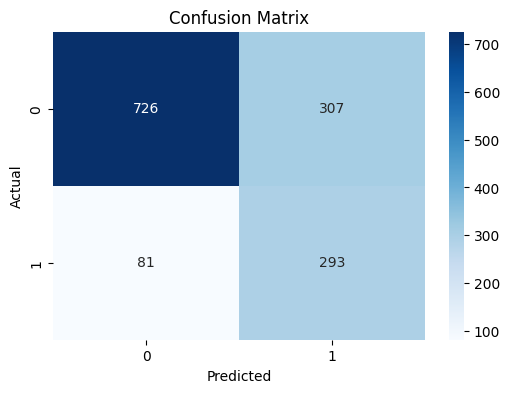

In [50]:
lr = LogisticRegression(C = 0.001, class_weight='balanced', penalty='l2', solver = 'lbfgs', random_state = 42, max_iter = 10000)
lr.fit(X_train_pca, y_train)
print(f"Accuracy train: {lr.score(X_train_pca, y_train):.4f}")
y_pred_pca = lr.predict(X_test_pca)
# 1️⃣ Accuracy
acc = accuracy_score(y_test, y_pred_pca)
print(f"Accuracy: {acc:.4f}")

# 2️⃣ Precision
prec = precision_score(y_test, y_pred_pca)
print(f"Precision: {prec:.4f}")

# 3️⃣ Recall
rec = recall_score(y_test, y_pred_pca)
print(f"Recall: {rec:.4f}")

# 4️⃣ F1-score
f1 = f1_score(y_test, y_pred_pca)
print(f"F1-score: {f1:.4f}")

# 5️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred_pca)
print("Confusion Matrix:")
print(cm)

# 6️⃣ Hoặc in nhanh tất cả các chỉ số cho từng lớp
print("\nClassification Report:")
print(classification_report(y_test, y_pred_pca))

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

MAE: 0.0156446085520949
MSE: 0.0003902960645553326
R² train: 0.9928123331152257
R² test: 0.9930127518680251


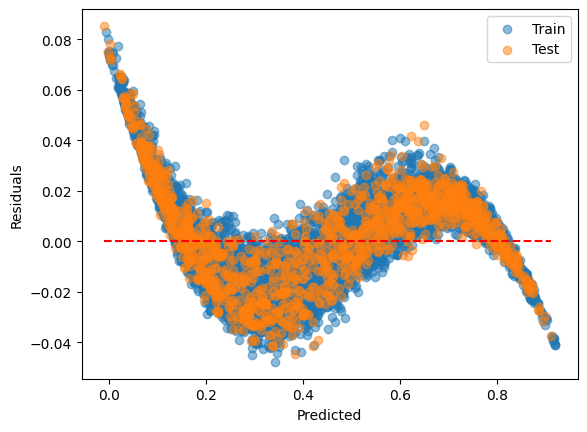

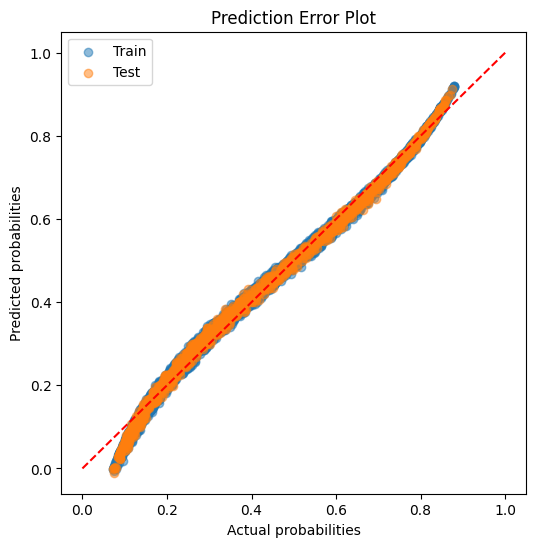

In [53]:
## Lấy ra xác suất của train và test làm nhãn y cho bài toán hồi quy
y_train_regr_pca = lr.predict_proba(X_train_pca)[:, 1]
y_test_regr_pca = lr.predict_proba(X_test_pca)[:, 1]

linr_pca = LinearRegression()
linr_pca.fit(X_train_pca,y_train_regr)
y_test_pred_regr_pca = linr_pca.predict(X_test_pca)
y_train_pred_regr_pca = linr_pca.predict(X_train_pca)
mae = mean_absolute_error(y_test_regr_pca, y_test_pred_regr_pca)
mse = mean_squared_error(y_test_regr_pca, y_test_pred_regr_pca)
r2_test = r2_score(y_test_regr_pca, y_test_pred_regr_pca)
r2_train = r2_score(y_train_regr_pca, y_train_pred_regr_pca)
print("MAE:", mae)
print("MSE:", mse)
print("R² train:", r2_train)
print("R² test:", r2_test)

# Vẽ Residual plot
residuals_train = y_train_regr_pca - y_train_pred_regr_pca
residuals_test = y_test_regr_pca - y_test_pred_regr_pca

plt.scatter(y_train_pred_regr_pca, residuals_train, label="Train", alpha=0.5)
plt.scatter(y_test_pred_regr_pca, residuals_test, label="Test", alpha=0.5)
plt.hlines(0, min(y_test_pred_regr_pca), max(y_test_pred_regr_pca), colors='r', linestyles='dashed')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.legend()
plt.show()

# Prediction Error Plot
plt.figure(figsize=(6,6))
plt.scatter(y_train_regr_pca, y_train_pred_regr_pca, alpha=0.5, label="Train")
plt.scatter(y_test_regr_pca, y_test_pred_regr_pca, alpha=0.5, label="Test")
plt.plot([0, 1], [0, 1], 'r--')  # đường y = x
plt.xlabel("Actual probabilities")
plt.ylabel("Predicted probabilities")
plt.title("Prediction Error Plot")
plt.legend()
plt.show()


#### LDA

Accuracy train: 0.7613
Accuracy: 0.7572
Precision: 0.5295
Recall: 0.7807
F1-score: 0.6310
Confusion Matrix:
[[1546  519]
 [ 164  584]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      2065
           1       0.53      0.78      0.63       748

    accuracy                           0.76      2813
   macro avg       0.72      0.76      0.73      2813
weighted avg       0.80      0.76      0.77      2813



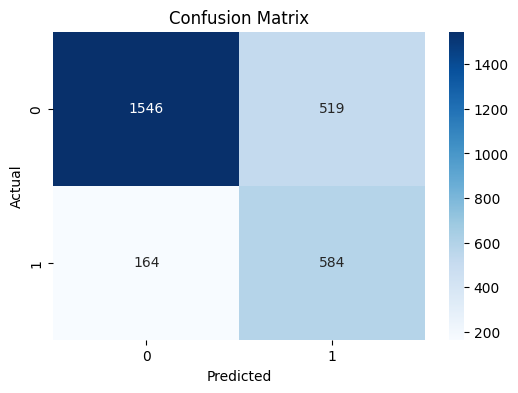

In [31]:
lr = LogisticRegression(C = 0.001, class_weight='balanced', penalty='l2', solver = 'lbfgs', random_state = 42, max_iter = 10000)
lr.fit(X_train_lda, y_train)
print(f"Accuracy train: {lr.score(X_train_lda, y_train):.4f}")
y_pred_lda = lr.predict(X_test_lda)
# 1️⃣ Accuracy
acc = accuracy_score(y_test, y_pred_lda)
print(f"Accuracy: {acc:.4f}")

# 2️⃣ Precision
prec = precision_score(y_test, y_pred_lda)
print(f"Precision: {prec:.4f}")

# 3️⃣ Recall
rec = recall_score(y_test, y_pred_lda)
print(f"Recall: {rec:.4f}")

# 4️⃣ F1-score
f1 = f1_score(y_test, y_pred_lda)
print(f"F1-score: {f1:.4f}")

# 5️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lda)
print("Confusion Matrix:")
print(cm)

# 6️⃣ Hoặc in nhanh tất cả các chỉ số cho từng lớp
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lda))

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Tỷ lệ 7:3

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, train_size=0.7, random_state=42, stratify=y_processed)

### Giảm chiều với PCA

In [33]:
# Tìm số chiều tối ưu cho PCA với phương sai giữ lại 0,9
pca73 = PCA(n_components=0.9)
X_train_pca = pca73.fit_transform(X_train)
X_test_pca = pca73.transform(X_test)
print(X_train_pca.shape)

(4922, 15)


### Giảm chiều với LDA

In [34]:
lda73 = LDA(n_components=1)
X_train_lda = lda73.fit_transform(X_train, y_train)
X_test_lda = lda73.transform(X_test)
print(X_train_lda.shape)

(4922, 1)


### Tìm siêu tham số với từng phương pháp

Original best params: {'C': np.float64(10.0), 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}
Original best recall: 0.810
PCA best params: {'C': np.float64(0.001), 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
PCA best recall: 0.803
LDA best params: {'C': np.float64(0.001), 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
LDA best recall: 0.770


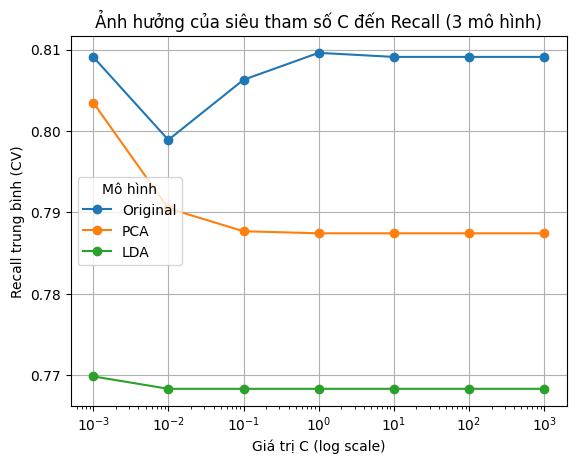

In [35]:
param_grid = {
    'C': np.logspace(-3, 3, 7),
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga', 'newton-cg'],
    'class_weight': ['balanced']
}

models = {
    "Original": X_train,
    "PCA": X_train_pca,
    "LDA": X_train_lda
}

for name, X in models.items():
    grid = GridSearchCV(LogisticRegression(max_iter=10000, random_state = 42), param_grid, cv=5, scoring='recall')
    grid.fit(X, y_train)
    print(f"{name} best params: {grid.best_params_}")
    print(f"{name} best recall: {grid.best_score_:.3f}")
    results = grid.cv_results_
    C_values = np.array(results['param_C'], dtype=float)
    mean_recalls = results['mean_test_score']

    # Gộp recall trung bình theo từng giá trị C
    unique_C = np.unique(C_values)
    avg_recalls = [np.mean(mean_recalls[C_values == c]) for c in unique_C]

    # Vẽ mỗi mô hình là một đường
    plt.plot(unique_C, avg_recalls, marker='o', label=name)

# Định dạng biểu đồ
plt.xscale('log')
plt.xlabel('Giá trị C (log scale)')
plt.ylabel('Recall trung bình (CV)')
plt.title('Ảnh hưởng của siêu tham số C đến Recall (3 mô hình)')
plt.grid(True)
plt.legend(title='Mô hình')
plt.show()



### Áp dụng vào mô hình

#### Dữ liệu gốc

Accuracy train: 0.7422
Accuracy: 0.7237
Precision: 0.4880
Recall: 0.7950
F1-score: 0.6047
Confusion Matrix:
[[1081  468]
 [ 115  446]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1549
           1       0.49      0.80      0.60       561

    accuracy                           0.72      2110
   macro avg       0.70      0.75      0.70      2110
weighted avg       0.79      0.72      0.74      2110



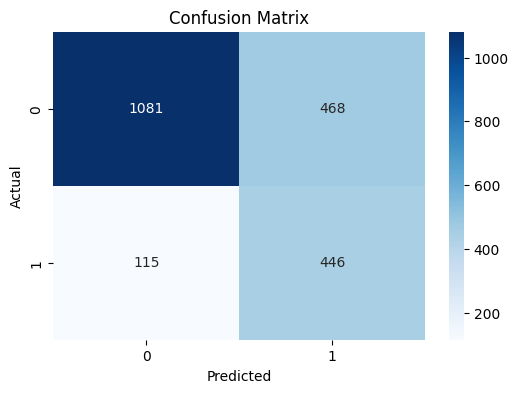

In [36]:
lr73 = LogisticRegression(C = 0.001, class_weight='balanced', penalty='l2', solver = 'lbfgs', random_state = 42, max_iter = 10000)
lr73.fit(X_train, y_train)
print(f"Accuracy train: {lr73.score(X_train, y_train):.4f}")
y_pred = lr73.predict(X_test)

# 1️⃣ Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

# 2️⃣ Precision
prec = precision_score(y_test, y_pred)
print(f"Precision: {prec:.4f}")

# 3️⃣ Recall
rec = recall_score(y_test, y_pred)
print(f"Recall: {rec:.4f}")

# 4️⃣ F1-score
f1 = f1_score(y_test, y_pred)
print(f"F1-score: {f1:.4f}")

# 5️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# 6️⃣ Hoặc in nhanh tất cả các chỉ số cho từng lớp
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#### PCA

Accuracy train: 0.7424
Accuracy: 0.7213
Precision: 0.4852
Recall: 0.7914
F1-score: 0.6016
Confusion Matrix:
[[1078  471]
 [ 117  444]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1549
           1       0.49      0.79      0.60       561

    accuracy                           0.72      2110
   macro avg       0.69      0.74      0.69      2110
weighted avg       0.79      0.72      0.74      2110



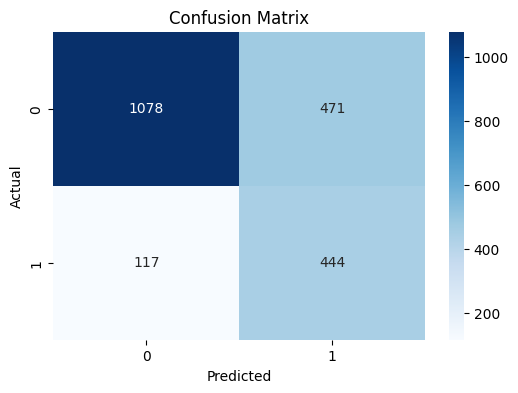

In [37]:
lr73 = LogisticRegression(C = 0.001, class_weight='balanced', penalty='l2', solver = 'lbfgs', random_state = 42, max_iter = 10000)
lr73.fit(X_train_pca, y_train)
print(f"Accuracy train: {lr73.score(X_train_pca, y_train):.4f}")
y_pred_pca = lr73.predict(X_test_pca)
# 1️⃣ Accuracy
acc = accuracy_score(y_test, y_pred_pca)
print(f"Accuracy: {acc:.4f}")

# 2️⃣ Precision
prec = precision_score(y_test, y_pred_pca)
print(f"Precision: {prec:.4f}")

# 3️⃣ Recall
rec = recall_score(y_test, y_pred_pca)
print(f"Recall: {rec:.4f}")

# 4️⃣ F1-score
f1 = f1_score(y_test, y_pred_pca)
print(f"F1-score: {f1:.4f}")

# 5️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred_pca)
print("Confusion Matrix:")
print(cm)

# 6️⃣ Hoặc in nhanh tất cả các chỉ số cho từng lớp
print("\nClassification Report:")
print(classification_report(y_test, y_pred_pca))

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#### LDA

Accuracy train: 0.7633
Accuracy: 0.7550
Precision: 0.5272
Recall: 0.7594
F1-score: 0.6224
Confusion Matrix:
[[1167  382]
 [ 135  426]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1549
           1       0.53      0.76      0.62       561

    accuracy                           0.75      2110
   macro avg       0.71      0.76      0.72      2110
weighted avg       0.80      0.75      0.77      2110



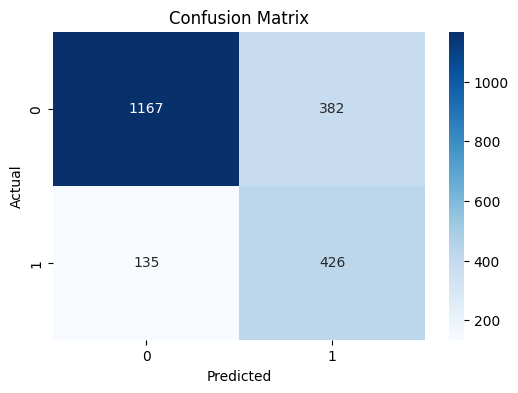

In [38]:
lr73 = LogisticRegression(C = 0.001, class_weight='balanced', penalty='l2', solver = 'lbfgs', random_state = 42, max_iter = 10000)
lr73.fit(X_train_lda, y_train)
print(f"Accuracy train: {lr73.score(X_train_lda, y_train):.4f}")
y_pred_lda = lr73.predict(X_test_lda)
# 1️⃣ Accuracy
acc = accuracy_score(y_test, y_pred_lda)
print(f"Accuracy: {acc:.4f}")

# 2️⃣ Precision
prec = precision_score(y_test, y_pred_lda)
print(f"Precision: {prec:.4f}")

# 3️⃣ Recall
rec = recall_score(y_test, y_pred_lda)
print(f"Recall: {rec:.4f}")

# 4️⃣ F1-score
f1 = f1_score(y_test, y_pred_lda)
print(f"F1-score: {f1:.4f}")

# 5️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lda)
print("Confusion Matrix:")
print(cm)

# 6️⃣ Hoặc in nhanh tất cả các chỉ số cho từng lớp
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lda))

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Tỷ lệ 8:2

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, train_size=0.8, random_state=42, stratify=y_processed)

### Giảm chiều với PCA

In [40]:
# Tìm số chiều tối ưu cho PCA với phương sai giữ lại 0,9
pca82 = PCA(n_components=0.9)
X_train_pca = pca82.fit_transform(X_train)
X_test_pca = pca82.transform(X_test)
print(X_train_pca.shape)

(5625, 15)


### Giảm chiều với LDA

In [41]:
lda82 = LDA(n_components=1)
X_train_lda = lda82.fit_transform(X_train, y_train)
X_test_lda = lda82.transform(X_test)
print(X_train_lda.shape)

(5625, 1)


### Tìm siêu tham số

Original best params: {'C': np.float64(0.001), 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
Original best recall: 0.805
PCA best params: {'C': np.float64(0.001), 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
PCA best recall: 0.798
LDA best params: {'C': np.float64(0.001), 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}
LDA best recall: 0.774


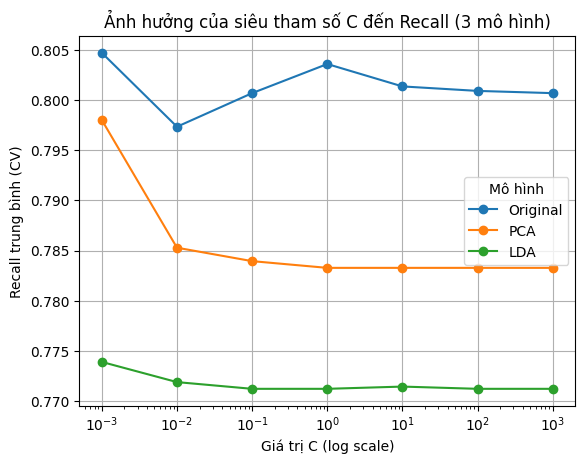

In [42]:
param_grid = {
    'C': np.logspace(-3, 3, 7),
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga', 'newton-cg'],
    'class_weight': ['balanced']
}

models = {
    "Original": X_train,
    "PCA": X_train_pca,
    "LDA": X_train_lda
}

for name, X in models.items():
    grid = GridSearchCV(LogisticRegression(max_iter=10000, random_state = 42), param_grid, cv=5, scoring='recall')
    grid.fit(X, y_train)
    print(f"{name} best params: {grid.best_params_}")
    print(f"{name} best recall: {grid.best_score_:.3f}")
    results = grid.cv_results_
    C_values = np.array(results['param_C'], dtype=float)
    mean_recalls = results['mean_test_score']

    # Gộp recall trung bình theo từng giá trị C
    unique_C = np.unique(C_values)
    avg_recalls = [np.mean(mean_recalls[C_values == c]) for c in unique_C]

    # Vẽ mỗi mô hình là một đường
    plt.plot(unique_C, avg_recalls, marker='o', label=name)
    

# Định dạng biểu đồ
plt.xscale('log')
plt.xlabel('Giá trị C (log scale)')
plt.ylabel('Recall trung bình (CV)')
plt.title('Ảnh hưởng của siêu tham số C đến Recall (3 mô hình)')
plt.grid(True)
plt.legend(title='Mô hình')
plt.show()



### Áp dụng vào từng mô hình

#### Dữ liệu gốc

Accuracy train: 0.7458
Accuracy: 0.7235
Precision: 0.4875
Recall: 0.7834
F1-score: 0.6010
Confusion Matrix:
[[725 308]
 [ 81 293]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.78      0.60       374

    accuracy                           0.72      1407
   macro avg       0.69      0.74      0.69      1407
weighted avg       0.79      0.72      0.74      1407



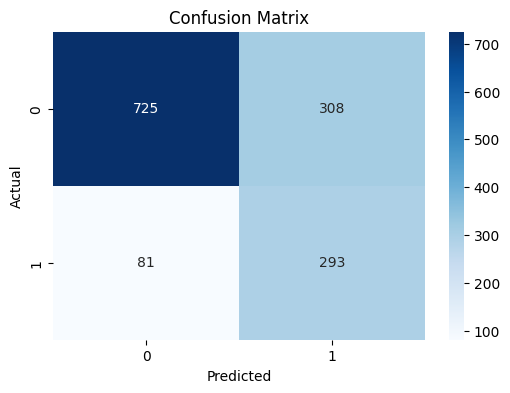

In [43]:
lr82 = LogisticRegression(C = 0.001, class_weight='balanced', penalty='l2', solver = 'lbfgs', random_state = 42, max_iter = 10000)
lr82.fit(X_train, y_train)
print(f"Accuracy train: {lr82.score(X_train, y_train):.4f}")
y_pred = lr82.predict(X_test)
# 1️⃣ Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

# 2️⃣ Precision
prec = precision_score(y_test, y_pred)
print(f"Precision: {prec:.4f}")

# 3️⃣ Recall
rec = recall_score(y_test, y_pred)
print(f"Recall: {rec:.4f}")

# 4️⃣ F1-score
f1 = f1_score(y_test, y_pred)
print(f"F1-score: {f1:.4f}")

# 5️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# 6️⃣ Hoặc in nhanh tất cả các chỉ số cho từng lớp
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#### PCA

Accuracy train: 0.7424
Accuracy: 0.7242
Precision: 0.4883
Recall: 0.7834
F1-score: 0.6016
Confusion Matrix:
[[726 307]
 [ 81 293]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.78      0.60       374

    accuracy                           0.72      1407
   macro avg       0.69      0.74      0.70      1407
weighted avg       0.79      0.72      0.74      1407



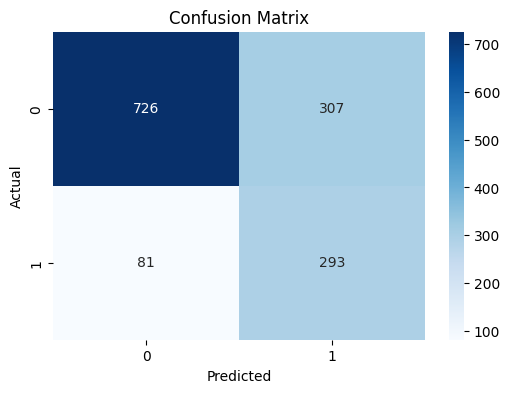

In [44]:
lr82 = LogisticRegression(C = 0.001, class_weight='balanced', penalty='l2', solver = 'lbfgs', random_state = 42, max_iter = 10000)
lr82.fit(X_train_pca, y_train)
print(f"Accuracy train: {lr82.score(X_train_pca, y_train):.4f}")
y_pred_pca = lr82.predict(X_test_pca)
# 1️⃣ Accuracy
acc = accuracy_score(y_test, y_pred_pca)
print(f"Accuracy: {acc:.4f}")

# 2️⃣ Precision
prec = precision_score(y_test, y_pred_pca)
print(f"Precision: {prec:.4f}")

# 3️⃣ Recall
rec = recall_score(y_test, y_pred_pca)
print(f"Recall: {rec:.4f}")

# 4️⃣ F1-score
f1 = f1_score(y_test, y_pred_pca)
print(f"F1-score: {f1:.4f}")

# 5️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred_pca)
print("Confusion Matrix:")
print(cm)

# 6️⃣ Hoặc in nhanh tất cả các chỉ số cho từng lớp
print("\nClassification Report:")
print(classification_report(y_test, y_pred_pca))

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#### LDA

Accuracy train: 0.7643
Accuracy: 0.7484
Precision: 0.5185
Recall: 0.7513
F1-score: 0.6135
Confusion Matrix:
[[772 261]
 [ 93 281]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.75      0.81      1033
           1       0.52      0.75      0.61       374

    accuracy                           0.75      1407
   macro avg       0.71      0.75      0.71      1407
weighted avg       0.79      0.75      0.76      1407



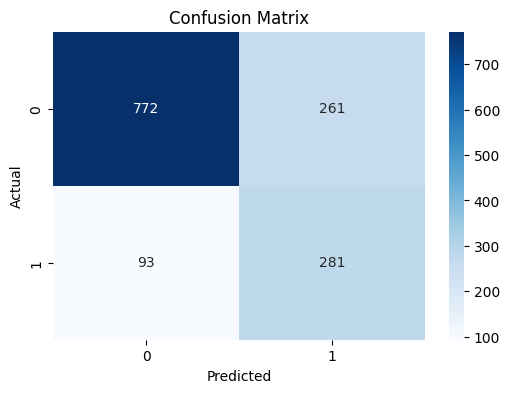

In [45]:
lr82 = LogisticRegression(C = 0.001, class_weight='balanced', penalty='l2', solver = 'lbfgs', random_state = 42, max_iter = 10000)
lr82.fit(X_train_lda, y_train)
print(f"Accuracy train: {lr82.score(X_train_lda, y_train):.4f}")
y_pred_lda = lr82.predict(X_test_lda)
# 1️⃣ Accuracy
acc = accuracy_score(y_test, y_pred_lda)
print(f"Accuracy: {acc:.4f}")

# 2️⃣ Precision
prec = precision_score(y_test, y_pred_lda)
print(f"Precision: {prec:.4f}")

# 3️⃣ Recall
rec = recall_score(y_test, y_pred_lda)
print(f"Recall: {rec:.4f}")

# 4️⃣ F1-score
f1 = f1_score(y_test, y_pred_lda)
print(f"F1-score: {f1:.4f}")

# 5️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lda)
print("Confusion Matrix:")
print(cm)

# 6️⃣ Hoặc in nhanh tất cả các chỉ số cho từng lớp
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lda))

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

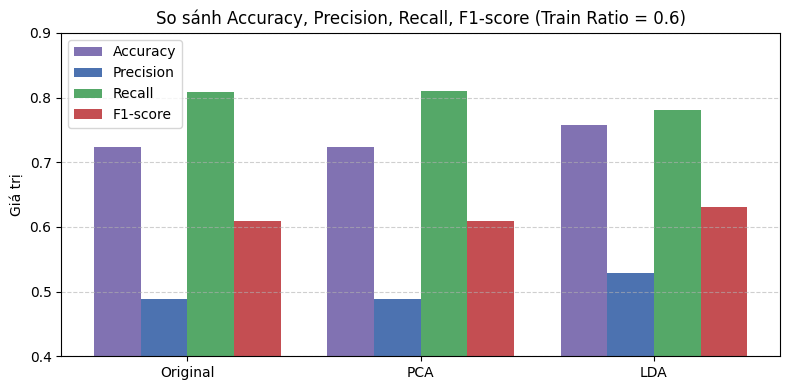

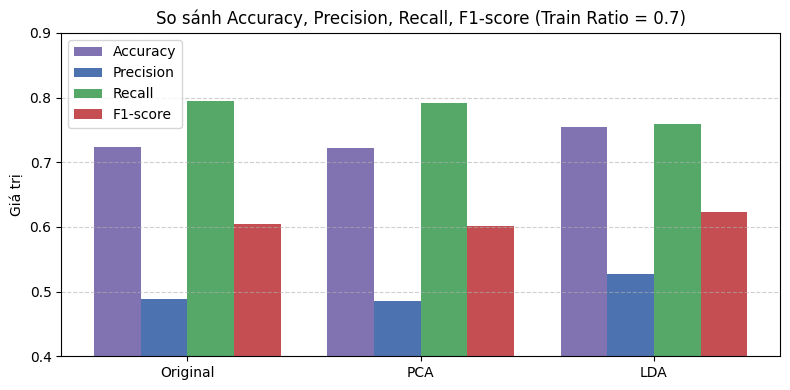

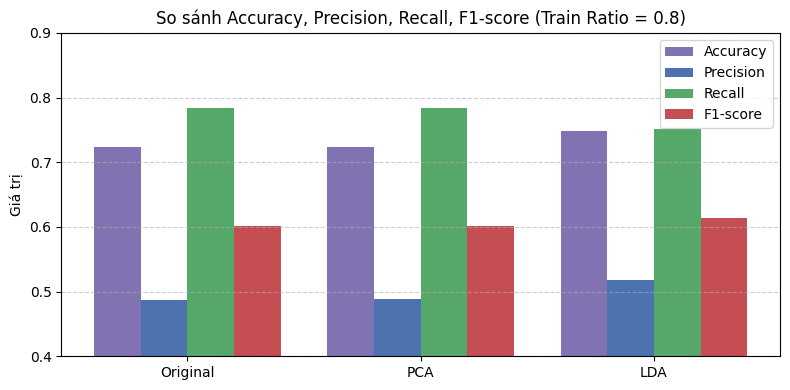

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# Dữ liệu từ bảng của Quang
data = {
    "Train Ratio": [0.6, 0.6, 0.6, 0.7, 0.7, 0.7, 0.8, 0.8, 0.8],
    "Method": ["Original", "PCA", "LDA"] * 3,
    "Accuracy": [0.7234, 0.7234, 0.7572, 0.7237, 0.7213, 0.7550, 0.7235, 0.7242, 0.7484],
    "Precision": [0.4879, 0.4879, 0.5295, 0.4880, 0.4852, 0.5272, 0.4875, 0.4883, 0.5185],
    "Recall": [0.8088, 0.8102, 0.7807, 0.7950, 0.7914, 0.7594, 0.7834, 0.7834, 0.7513],
    "F1-score": [0.6087, 0.6090, 0.6310, 0.6047, 0.6016, 0.6224, 0.6010, 0.6016, 0.6135],
}

df = pd.DataFrame(data)

# Vẽ lại, lần này thêm Accuracy
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
colors = ["#8172B2", "#4C72B0", "#55A868", "#C44E52"]

for ratio in df["Train Ratio"].unique():
    subset = df[df["Train Ratio"] == ratio]
    x = range(len(subset["Method"]))
    
    plt.figure(figsize=(8,4))
    for i, metric in enumerate(metrics):
        plt.bar(
            [p + i*0.2 for p in x],
            subset[metric],
            width=0.2,
            label=metric,
            color=colors[i]
        )
    
    plt.xticks([p + 0.3 for p in x], subset["Method"])
    plt.ylim(0.4, 0.9)
    plt.title(f"So sánh Accuracy, Precision, Recall, F1-score (Train Ratio = {ratio})")
    plt.ylabel("Giá trị")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()
